# Loading Script

In [1]:
import torch
import sys
import os
from pathlib import Path
import importlib.util
import huggingface_hub
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer

def download_and_setup_model(model_name="gbyuvd/ChemMiniQ3-SAbRLo", local_dir="./chemq3_model"):
    """Download model files and set up the custom modules"""
    
    print(f"📥 Downloading model files from {model_name}...")
    
    try:
        # Download all files to a local directory
        model_path = huggingface_hub.snapshot_download(
            repo_id=model_name,
            local_dir=local_dir,
            local_files_only=False,
            resume_download=True
        )
        
        print(f"✅ Model downloaded to: {model_path}")
        
        # List downloaded files
        print("📁 Downloaded files:")
        for file in Path(model_path).iterdir():
            if file.is_file():
                print(f"   {file.name} ({file.stat().st_size} bytes)")
        
        return Path(model_path)
        
    except Exception as e:
        print(f"❌ Download failed: {e}")
        return None

def load_custom_modules(model_path):
    """Load all the custom modules required by the model"""
    
    model_path = Path(model_path)
    
    # Add the model directory to Python path
    if str(model_path) not in sys.path:
        sys.path.insert(0, str(model_path))
    
    print(f"🔧 Loading custom modules from {model_path}...")
    
    # Required module files
    required_files = {
        'configuration_chemq3mtp.py': 'configuration_chemq3mtp',
        'modeling_chemq3mtp.py': 'modeling_chemq3mtp', 
        'FastChemTokenizerHF.py': 'FastChemTokenizerHF'
    }
    
    loaded_modules = {}
    
    # Load each required module
    for filename, module_name in required_files.items():
        file_path = model_path / filename
        
        if not file_path.exists():
            print(f"❌ Required file not found: {filename}")
            return None
            
        try:
            spec = importlib.util.spec_from_file_location(module_name, file_path)
            module = importlib.util.module_from_spec(spec)
            
            # Execute the module
            spec.loader.exec_module(module)
            loaded_modules[module_name] = module
            
            print(f"   ✅ Loaded {filename}")
            
        except Exception as e:
            print(f"   ❌ Failed to load {filename}: {e}")
            return None
    
    return loaded_modules

def register_model_components(loaded_modules):
    """Register the model components with transformers"""
    
    print("🔗 Registering model components...")
    
    try:
        # Get the classes from loaded modules
        ChemQ3MTPConfig = loaded_modules['configuration_chemq3mtp'].ChemQ3MTPConfig
        ChemQ3MTPForCausalLM = loaded_modules['modeling_chemq3mtp'].ChemQ3MTPForCausalLM
        FastChemTokenizerSelfies = loaded_modules['FastChemTokenizerHF'].FastChemTokenizerSelfies
        
        # Register with transformers
        AutoConfig.register("chemq3_mtp", ChemQ3MTPConfig)
        AutoModelForCausalLM.register(ChemQ3MTPConfig, ChemQ3MTPForCausalLM)
        AutoTokenizer.register(ChemQ3MTPConfig, FastChemTokenizerSelfies)
        
        print("✅ Model components registered successfully")
        
        return ChemQ3MTPConfig, ChemQ3MTPForCausalLM, FastChemTokenizerSelfies
        
    except Exception as e:
        print(f"❌ Registration failed: {e}")
        return None, None, None

def load_model(model_path):
    """Load the model using the registered components"""
    
    print("🚀 Loading model...")
    
    try:
        # Load config
        config = AutoConfig.from_pretrained(str(model_path), trust_remote_code=False)
        print(f"✅ Config loaded: {config.__class__.__name__}")
        
        # Load model
        model = AutoModelForCausalLM.from_pretrained(
            str(model_path),
            config=config,
            torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
            trust_remote_code=False  # We've already registered everything
        )
        print(f"✅ Model loaded: {model.__class__.__name__}")
        
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(str(model_path), trust_remote_code=False)
        print(f"✅ Tokenizer loaded: {tokenizer.__class__.__name__}")
        
        return model, tokenizer, config
        
    except Exception as e:
        print(f"❌ Model loading failed: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def test_model(model, tokenizer, config):
    """Test the loaded model"""
    
    print("\n🧪 Testing model...")
    
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🖥️  Using device: {device}")
    
    model = model.to(device)
    model.eval()
    
    # Model info
    print(f"\n📊 Model Information:")
    print(f"   Model class: {model.__class__.__name__}")
    print(f"   Config class: {config.__class__.__name__}")
    print(f"   Tokenizer class: {tokenizer.__class__.__name__}")
    print(f"   Model type: {config.model_type}")
    print(f"   Vocab size: {config.vocab_size}")
    
    # Set pad token if needed
    if not hasattr(tokenizer, 'pad_token') or tokenizer.pad_token is None:
        if hasattr(tokenizer, 'eos_token'):
            tokenizer.pad_token = tokenizer.eos_token
            print("✅ Set pad_token to eos_token")
    
    # Test tokenization
    print("\n🔤 Testing tokenization...")
    test_inputs = ["[C][C][O]", "[C]", "[O]"]
    
    for test_input in test_inputs:
        try:
            tokens = tokenizer(test_input, return_tensors="pt")
            print(f"   '{test_input}' -> {tokens.input_ids.tolist()}")
        except Exception as e:
            print(f"   ❌ Tokenization failed for '{test_input}': {e}")
            continue
    
    # Test generation
    print("\n🎯 Testing generation...")
    test_prompts = ["[C]", "[C][C]"]
    
    for prompt in test_prompts:
        try:
            input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
            
            with torch.no_grad():
                outputs = model.generate(
                    input_ids,
                    max_length=input_ids.shape[1] + 20,
                    temperature=0.8,
                    top_p=0.9,
                    top_k=50,
                    do_sample=True,
                    pad_token_id=tokenizer.pad_token_id if hasattr(tokenizer, 'pad_token_id') else 0,
                    num_return_sequences=3
                )
            
            print(f"\n   Prompt: '{prompt}'")
            for i, output in enumerate(outputs):
                generated = tokenizer.decode(output, skip_special_tokens=True)
                print(f"      {i+1}: {generated}")
                
        except Exception as e:
            print(f"   ❌ Generation failed for '{prompt}': {e}")
    
    # Test MTP functionality if available
    print("\n🔬 Testing MTP functionality...")
    try:
        if hasattr(model, 'set_mtp_training'):
            print("   ✅ MTP training methods available")
            if hasattr(model, 'generate_with_logprobs'):
                print("   ✅ MTP generation methods available")
        else:
            print("   ℹ️  Standard model - no MTP methods detected")
    except Exception as e:
        print(f"   ⚠️  MTP test error: {e}")

def main():
    print("🚀 ChemQ3-MTP Model Loader Starting...\n")
    
    model_name = "gbyuvd/ChemMiniQ3-SAbRLo"
    local_dir = "./chemq3_model"
    
    # Step 1: Download model files
    model_path = download_and_setup_model(model_name, local_dir)
    if model_path is None:
        return None, None, None
    
    print()
    
    # Step 2: Load custom modules
    loaded_modules = load_custom_modules(model_path)
    if loaded_modules is None:
        return None, None, None
    
    print()
    
    # Step 3: Register components
    config_class, model_class, tokenizer_class = register_model_components(loaded_modules)
    if config_class is None:
        return None, None, None
    
    print()
    
    # Step 4: Load the model
    model, tokenizer, config = load_model(model_path)
    if model is None:
        return None, None, None
    
    # Step 5: Test the model
    test_model(model, tokenizer, config)
    
    print("\n🎉 Model loading and testing completed successfully!")
    
    return model, tokenizer, config

if __name__ == "__main__":
    model, tokenizer, config = main()

🚀 ChemQ3-MTP Model Loader Starting...

📥 Downloading model files from gbyuvd/ChemMiniQ3-SAbRLo...


d:\ProgramData\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

FastChemTokenizerHF.py: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

__init__.py:   0%|          | 0.00/569 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

configuration_chemq3mtp.py:   0%|          | 0.00/876 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

demo_usage.ipynb: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/39.4M [00:00<?, ?B/s]

rl_utils.py: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/302 [00:00<?, ?B/s]

modeling_chemq3mtp.py: 0.00B [00:00, ?B/s]

trainer.py: 0.00B [00:00, ?B/s]

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

trainer_state.json:   0%|          | 0.00/798 [00:00<?, ?B/s]

training_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

✅ Model downloaded to: D:\Work\ChemMiniQ3-HoriFIE-main\ChemMiniQ3-HoriFIE-main\ChemMiniQ3-o\Automodel\chemq3_model
📁 Downloaded files:
   .gitattributes (1519 bytes)
   config.json (1161 bytes)
   configuration_chemq3mtp.py (876 bytes)
   demo_usage.ipynb (15239 bytes)
   FastChemTokenizerHF.py (28659 bytes)
   generation_config.json (174 bytes)
   model.safetensors (39437252 bytes)
   modeling_chemq3mtp.py (18125 bytes)
   README.md (8575 bytes)
   rl_utils.py (20726 bytes)
   tokenizer_config.json (302 bytes)
   trainer.py (2417 bytes)
   trainer_state.json (798 bytes)
   training_args.bin (5368 bytes)
   training_config.json (252 bytes)
   vocab.json (21574 bytes)
   __init__.py (569 bytes)

🔧 Loading custom modules from D:\Work\ChemMiniQ3-HoriFIE-main\ChemMiniQ3-HoriFIE-main\ChemMiniQ3-o\Automodel\chemq3_model...
   ✅ Loaded configuration_chemq3mtp.py


`torch_dtype` is deprecated! Use `dtype` instead!


   ✅ Loaded modeling_chemq3mtp.py
   ✅ Loaded FastChemTokenizerHF.py

🔗 Registering model components...
✅ Model components registered successfully

🚀 Loading model...
✅ Config loaded: ChemQ3MTPConfig
✅ Model loaded: ChemQ3MTPForCausalLM
✅ Tokenizer loaded: FastChemTokenizerSelfies

🧪 Testing model...
🖥️  Using device: cuda

📊 Model Information:
   Model class: ChemQ3MTPForCausalLM
   Config class: ChemQ3MTPConfig
   Tokenizer class: FastChemTokenizerSelfies
   Model type: chemq3_mtp
   Vocab size: 782

🔤 Testing tokenization...
   '[C][C][O]' -> [[0, 379, 379, 377, 1]]
   '[C]' -> [[0, 379, 1]]
   '[O]' -> [[0, 377, 1]]

🎯 Testing generation...

   Prompt: '[C]'
      1: [C] [C] [Ring1] [Branch1] [N] [C] [=Branch1] [C] [=O] [C] [=Branch1] [C] [=O] [N] [Branch1] [#Branch1] [C] [C] [=C] [C] [=C] [C] [=C] [Ring1] [=Branch1] [Ring1] [=Branch1]
      2: [C] [C] [=C] [Ring1] [Branch1] [C] [C] [Ring1] [=N] [C] [Branch1] [=Branch2] [C] [Branch2] [Ring1] [#Branch1] [Branch1] [C] [O] [C@@H1] [Ri

In [2]:
# Generate SELFIES
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_ids = tokenizer("<s>", return_tensors="pt").input_ids.to(device)
gen = model.generate(input_ids, max_length=256, top_k=50, temperature=1, do_sample=True, pad_token_id=tokenizer.pad_token_id)
print(tokenizer.decode(gen[0], skip_special_tokens=True))

[C@H1] [/C] [N] [Branch1] [N] [C] [=C] [C] [=C] [Branch1] [C] [Cl] [C] [=C] [C] [=C] [O] [Ring1] [=Branch1] [Ring2] [Ring1] [Ring1] [Ring1] [O] [C] [Branch1] [N] [C] [C@@H1] [Ring1] [=Branch1] [C] [C] [Ring1] [Branch2] [N] [C] [=Branch1] [C] [=O] [C] [=C] [Ring2] [Ring1] [Ring2] [O] [C] [C] [Ring1] [Ring1] [Ring2] [N] [C] [C] [Ring1] [Branch1]


In [3]:
# Manually convert it to SMILES
import selfies as sf

test = tokenizer.decode(gen[0], skip_special_tokens=True)
test = test.replace(' ', '')
print(sf.decoder(test))


[C@H1]/CN(C=CC=C(Cl)C=CC=C)O


C12=CC1(OCC=CC=C)C2


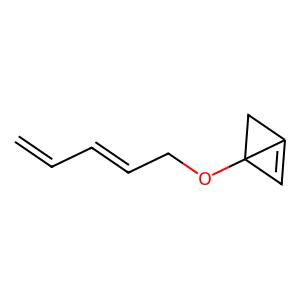

In [4]:
# Generate Mol Viz
from rdkit import Chem
from rdkit.Chem import Draw

input_ids = tokenizer("<s>", return_tensors="pt").input_ids.to(device)
gen = model.generate(input_ids, max_length=25, top_k=50, temperature=1, do_sample=True, pad_token_id=tokenizer.pad_token_id)
generatedmol = tokenizer.decode(gen[0], skip_special_tokens=True)

test = generatedmol.replace(' ', '')
csmi_gen = sf.decoder(test)
print(csmi_gen)
mol = Chem.MolFromSmiles(csmi_gen)

# Draw the molecule
Draw.MolToImage(mol)